In [268]:
import os
os.chdir('../')
import torch
import torch.nn as nn
import torch.nn.functional as tF
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

import functional as F

In [269]:
def label_to_membership(labels):
    n_class = labels.max() + 1
    n_samples = labels.shape[0]
    membership = torch.zeros(n_samples, n_class)
    for j in range(n_class):
        idx_j = labels == j
        membership[idx_j, j] = 1.
    return membership

In [270]:
class MCR2Variational(nn.Module):
    """Equation 10 in writeup. """
    def __init__(self, eps, mu):
        super(MCR2Variational, self).__init__()
        self.eps = eps
        self.mu = mu
        
    def loss_discrimn(self, Z):
        d, n = Z.shape
        I = torch.eye(d).to(Z.device)
        return 0.5 * torch.logdet(I + d / (n * self.eps) * Z @ Z.T)

    def loss_compress(self, Z, Pi, A):
        d, m = Z.shape
        _, k= Pi.shape
        I = torch.eye(d).to(Z.device)
        compress_loss = 0.
        ones = torch.ones(A.shape[1])
        for j in range(k):
            trPi = torch.sum(Pi[:,j])
            scalar = d / (trPi * eps)
            log_det = torch.sum(torch.log(ones + scalar * A[j]))
            compress_loss += log_det * trPi / m
        return compress_loss / 2

    def reg_UA(self, Z, Pi, A, U):
        _, k = Pi.shape
        matrix_loss = 0.
        for j in range(k):
            matrix_loss += torch.sum((Z@Pi[:,j].diag()@Z.T - U@torch.diag(A[j])@U.T)**2)
        return  matrix_loss / 2
    
    def forward(self, Z, Pi, A, U):
        loss_R = self.loss_discrimn(Z.T)
        loss_Rc = self.loss_compress(Z.T, Pi, A)
        loss_reg_U = self.mu *self.reg_UA(Z.T, Pi, A, U)
        loss_obj = loss_R - loss_Rc - loss_reg_U
        return -loss_obj, loss_R, loss_Rc, loss_reg_U

In [271]:
class MCR2(nn.Module):
    def __init__(self, eps=0.1):
        super(MCR2, self).__init__()
        self.eps = eps

    def compute_discrimn_loss(self, Z):
        """Theoretical Discriminative Loss."""
        d, n = Z.shape
        I = torch.eye(d).to(Z.device)
        scalar = d / (n * self.eps)
        logdet = torch.logdet(I + scalar * Z @ Z.T)
        return logdet / 2.

    def compute_compress_loss(self, Z, Pi):
        """Theoretical Compressive Loss."""
        d, n = Z.shape
        I = torch.eye(d).to(Z.device)
        compress_loss = 0.
        for j in range(Pi.shape[1]):
            trPi = Pi[:, j].sum()
            scalar = d / (trPi * self.eps)
            log_det = torch.logdet(I + scalar * Z @ Pi[:, j].diag() @ Z.T)
            compress_loss += trPi / (2 * n) * log_det
        return compress_loss

    def forward(self, Z, Pi):
        discrimn_loss = self.compute_discrimn_loss(Z.T)
        compress_loss = self.compute_compress_loss(Z.T, Pi)
        total_loss = discrimn_loss - compress_loss
        return -total_loss, discrimn_loss, compress_loss

## Almost Degenerate Gaussian Data

In [273]:
def initialize_gaussian(n_class=2, n_features=4, n_samples=100, eps=0.1, mu=10, r=4):
    class1 = torch.distributions.MultivariateNormal(torch.tensor([0.0,0,0,0]), torch.tensor([1.0,0.5,1e-6,0.1]).diag())
    class2 = torch.distributions.MultivariateNormal(torch.tensor([0.0,0,0,0]), torch.tensor([1e-6,0.1,1.0,0.5]).diag())
    Z_train = torch.stack([class1.sample() for i in range(n_samples)] + 
                           [class2.sample() for i in range(n_samples)])
    Z_train = F.normalize(Z_train)
    Pi = torch.zeros(2*n_samples, 2)
    Pi[:n_samples, 0] = 1.
    Pi[n_samples:, 1] = 1.

    #Low rank approx
    U1, S1, V1 = torch.linalg.svd(Z_train[:n_samples].T@Z_train[:n_samples])
    U2, S2, V2 = torch.linalg.svd(Z_train[n_samples:].T@Z_train[n_samples:])
    plt.imshow(np.abs(Z_train@Z_train.T))
    plt.colorbar()
    U = torch.cat((U1[:,:r], U2[:,:r]), dim=1)
    Z = nn.Parameter(
        Z_train.clone(),
        requires_grad=True
        )
    U = nn.Parameter(
        U,
        requires_grad=True
        )
    A = nn.Parameter(
        torch.stack( (torch.tensor([S1[i] for i in range(r)] + [0,0,0,0]), torch.tensor([0,0,0,0] + [S2[i] for i in range(r)]))),
        requires_grad=True
        )
    return Z, U, A, Pi

## Alternating Projected Gradient

Var MCR 0.9720692038536072 4.786370277404785 3.814301013946533 5.6074288323770816e-08
True MCR 0.972069263458252 4.786370277404785 3.814301013946533


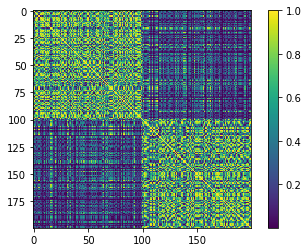

In [289]:
mu=100
Z, U, A, Pi = initialize_gaussian(mu=mu)
criterion_mcr2var = MCR2Variational(eps, mu)
criterion_mcr = MCR2(eps)
loss_obj, loss_R, loss_Rc, loss_reg_U = criterion_mcr2var(Z, Pi, A, U)
true_obj, true_R, true_Rc = criterion_mcr(Z, Pi)

print('Var MCR', -loss_obj.item(), loss_R.item(), loss_Rc.item(), loss_reg_U.item())
print('True MCR', -true_obj.item(), true_R.item(), true_Rc.item())

In [290]:
optimizer_au = optim.SGD([A, U], lr=1e-4)
optimizer_z = optim.SGD([Z], lr=1e-3)

loss_dict = {'E':[], 'C':[], 'M':[]}
true_dict = {'E':[], 'C':[]}
norm = {'U':[], 'A':[]}
Z_n = F.normalize(Z)
for epoch in range(500):
    if epoch % 1 == 0:
        Z_n = tF.normalize(Z)
        loss_obj, loss_R, loss_Rc, loss_reg_U = criterion_mcr2var(Z_n, Pi, A, U)
        true_obj, true_R, true_Rc = criterion_mcr(Z_n, Pi)
        print(epoch, - loss_obj.item(), loss_R.item(), loss_Rc.item(), loss_reg_U.item())
        print(epoch, - true_obj.item(), true_R.item(), true_Rc.item())
            
        loss_dict['E'].append(loss_R.item())
        loss_dict['C'].append(loss_Rc.item())
        loss_dict['M'].append(loss_reg_U.item())
        true_dict['E'].append(true_R.item())
        true_dict['C'].append(true_Rc.item())
        
        
    for step in range(1):
        optimizer_z.zero_grad()
        Z_n = tF.normalize(Z)
        loss_obj = criterion_mcr2var(Z_n, Pi, A, U)
        loss_obj[0].backward()
        optimizer_z.step()
    for step in range(1):
        optimizer_au.zero_grad()
        Z_n = tF.normalize(Z, dim=1)
        loss_obj = criterion_mcr2var(Z_n, Pi, A, U)
        loss_obj[3].backward()
        a1 = torch.norm(A.grad)
        u1 = torch.norm(U.grad)
        optimizer_au.step()
        optimizer_au.zero_grad()
        loss_obj[2].backward()
        a2 = torch.norm(A.grad)
        u2 = torch.norm(U.grad)
        optimizer_au.step()
        norm['A'].append([a1, a2])
        norm['U'].append([u1, u2])
        with torch.no_grad():
            A.data = tF.relu(A.data)
            U.data = torch.nn.functional.normalize(U.data, dim = 0)

0 0.9720692038536072 4.786370277404785 3.814301013946533 4.922918606098392e-08
0 0.9720690250396729 4.786370277404785 3.8143012523651123
1 0.9657827019691467 4.786371231079102 3.8142988681793213 0.0062896497547626495
1 0.9720702171325684 4.786371231079102 3.814301013946533
2 -1801.5028076171875 4.7864837646484375 3.8143272399902344 1802.4749755859375
2 0.972163200378418 4.7864837646484375 3.8143205642700195
3 -334212.5625 4.631615161895752 3.837752342224121 334213.34375
3 0.8401660919189453 4.631615161895752 3.7914490699768066
4 -622513.75 4.318997383117676 3.884552478790283 622514.1875
4 0.29331302642822266 4.318997383117676 4.025684356689453
5 -488488.59375 4.659168243408203 3.9209532737731934 488489.34375
5 0.3647007942199707 4.659168243408203 4.294467449188232
6 -276760.625 4.61257266998291 3.9691429138183594 276761.28125
6 0.45380640029907227 4.61257266998291 4.158766269683838
7 -184406.5 4.4870429039001465 4.003422260284424 184406.984375
7 0.5916953086853027 4.4870429039001465 3.

67 -149026.46875 4.762826919555664 5.06707763671875 149026.171875
67 0.02252674102783203 4.762826919555664 4.740300178527832
68 -139238.46875 4.766384601593018 5.108273029327393 139238.125
68 0.025812625885009766 4.766384601593018 4.740571975708008
69 -125473.8125 4.768592357635498 5.1399736404418945 125473.4375
69 0.02894449234008789 4.768592357635498 4.73964786529541
70 -128238.890625 4.766922950744629 5.154458045959473 128238.5
70 0.031609535217285156 4.766922950744629 4.735313415527344
71 -146600.734375 4.761942386627197 5.144002914428711 146600.359375
71 0.028457164764404297 4.761942386627197 4.733485221862793
72 -158178.0625 4.758353233337402 5.148003101348877 158177.671875
72 0.018543243408203125 4.758353233337402 4.739809989929199
73 -156285.765625 4.760562419891357 5.197270393371582 156285.328125
73 0.01048135757446289 4.760562419891357 4.7500810623168945
74 -138679.046875 4.766873836517334 5.259320259094238 138678.546875
74 0.008689403533935547 4.766873836517334 4.75818443298

132 0.0028200149536132812 4.652923107147217 4.6501030921936035
133 -211605.1875 4.660856246948242 4.67740535736084 211605.171875
133 0.00246429443359375 4.660856246948242 4.658391952514648
134 -206390.203125 4.671381950378418 4.637955665588379 206390.234375
134 0.0024514198303222656 4.671381950378418 4.668930530548096
135 -209006.6875 4.687826633453369 4.612658977508545 209006.765625
135 0.0025930404663085938 4.687826633453369 4.6852335929870605
136 -192490.796875 4.703072547912598 4.5938005447387695 192490.90625
136 0.0022058486938476562 4.703072547912598 4.70086669921875
137 -162106.40625 4.7141194343566895 4.5786566734313965 162106.546875
137 0.0011506080627441406 4.7141194343566895 4.712968826293945
138 -126333.9296875 4.7200517654418945 4.578861236572266 126334.0703125
138 0.0007448196411132812 4.7200517654418945 4.719306945800781
139 -74811.03125 4.720029830932617 4.594663143157959 74811.15625
139 0.0008511543273925781 4.720029830932617 4.719178676605225
140 -91390.0 4.7169704437

196 -81201.2421875 4.785704612731934 5.858280181884766 81200.171875
196 0.0027685165405273438 4.785704612731934 4.782936096191406
197 -59472.0390625 4.7856316566467285 5.862027168273926 59470.9609375
197 0.0018634796142578125 4.7856316566467285 4.783768177032471
198 -54015.16796875 4.7851457595825195 5.8785786628723145 54014.07421875
198 0.0013937950134277344 4.7851457595825195 4.783751964569092
199 -76411.578125 4.7841691970825195 5.897695541381836 76410.4609375
199 0.0014028549194335938 4.7841691970825195 4.782766342163086
200 -133236.921875 4.7872443199157715 5.907697677612305 133235.796875
200 0.0011706352233886719 4.7872443199157715 4.786073684692383
201 -95467.3515625 4.78401517868042 5.883945465087891 95466.25
201 0.0017313957214355469 4.78401517868042 4.782283782958984
202 -52566.796875 4.774101734161377 5.873283386230469 52565.69921875
202 0.001960277557373047 4.774101734161377 4.772141456604004
203 -71050.1875 4.769184112548828 5.884303569793701 71049.0703125
203 0.0024089813

267 -39912.09375 4.753263473510742 5.615822792053223 39911.23046875
267 0.0016016960144042969 4.753263473510742 4.751661777496338
268 -59075.1953125 4.753096580505371 5.645538330078125 59074.3046875
268 0.0018420219421386719 4.753096580505371 4.751254558563232
269 -108078.015625 4.7547197341918945 5.669316291809082 108077.1015625
269 0.0019865036010742188 4.7547197341918945 4.75273323059082
270 -70242.1796875 4.749543190002441 5.65479850769043 70241.2734375
270 0.002452850341796875 4.749543190002441 4.7470903396606445
271 -80897.5859375 4.753731727600098 5.673246383666992 80896.6640625
271 0.00257110595703125 4.753731727600098 4.751160621643066
272 -89461.828125 4.757753372192383 5.686362266540527 89460.8984375
272 0.002537250518798828 4.757753372192383 4.755216121673584
273 -75590.40625 4.75789213180542 5.6884331703186035 75589.4765625
273 0.0021543502807617188 4.75789213180542 4.755737781524658
274 -111899.7734375 4.758946895599365 5.703679084777832 111898.828125
274 0.00184822082519

333 -177346.5 4.773448944091797 5.9939751625061035 177345.28125
333 0.0008516311645507812 4.773448944091797 4.772597312927246
334 -171037.96875 4.7757062911987305 5.948092937469482 171036.796875
334 0.0009860992431640625 4.7757062911987305 4.774720191955566
335 -161570.859375 4.776927947998047 5.904605388641357 161569.734375
335 0.0014219284057617188 4.776927947998047 4.775506019592285
336 -141578.53125 4.775506019592285 5.861900329589844 141577.4375
336 0.002193450927734375 4.775506019592285 4.773312568664551
337 -108490.3359375 4.7720794677734375 5.828919410705566 108489.28125
337 0.003162384033203125 4.7720794677734375 4.768917083740234
338 -59849.68359375 4.768733501434326 5.810812473297119 59848.640625
338 0.0035719871520996094 4.768733501434326 4.765161514282227
339 -74782.953125 4.767666816711426 5.822548866271973 74781.8984375
339 0.004034996032714844 4.767666816711426 4.763631820678711
340 -92079.8828125 4.766056060791016 5.828407287597656 92078.8203125
340 0.00440120697021484

402 0.0003495216369628906 4.770772457122803 4.77042293548584
403 -61067.87890625 4.774526596069336 5.893268585205078 61066.76171875
403 0.0004124641418457031 4.774526596069336 4.77411413192749
404 -109612.1953125 4.773786544799805 5.905385494232178 109611.0625
404 0.0003857612609863281 4.773786544799805 4.773400783538818
405 -67361.09375 4.776823043823242 5.899753093719482 67359.96875
405 0.0005178451538085938 4.776823043823242 4.776305198669434
406 -68714.609375 4.7798004150390625 5.912129878997803 68713.4765625
406 0.0006284713745117188 4.7798004150390625 4.779171943664551
407 -131954.921875 4.7793192863464355 5.919582366943359 131953.78125
407 0.000576019287109375 4.7793192863464355 4.778743267059326
408 -106387.2734375 4.778877258300781 5.897920608520508 106386.15625
408 0.0008563995361328125 4.778877258300781 4.778020858764648
409 -79586.4453125 4.774572849273682 5.885924816131592 79585.3359375
409 0.001064300537109375 4.774572849273682 4.773508548736572
410 -39257.12890625 4.7729

467 -41404.015625 4.776564121246338 5.9404616355896 41402.8515625
467 0.0007033348083496094 4.776564121246338 4.775860786437988
468 -70632.7265625 4.775798320770264 5.96036958694458 70631.5390625
468 0.0006260871887207031 4.775798320770264 4.775172233581543
469 -79890.6953125 4.778660297393799 5.970081329345703 79889.5
469 0.0006070137023925781 4.778660297393799 4.778053283691406
470 -150517.03125 4.777361869812012 5.9701690673828125 150515.84375
470 0.0006613731384277344 4.777361869812012 4.776700496673584
471 -129236.890625 4.7800517082214355 5.94279670715332 129235.7265625
471 0.0004706382751464844 4.7800517082214355 4.779581069946289
472 -91535.7109375 4.778052806854248 5.920095443725586 91534.5703125
472 0.00042819976806640625 4.778052806854248 4.777624607086182
473 -34695.11328125 4.775431156158447 5.914493560791016 34693.97265625
473 0.00047969818115234375 4.775431156158447 4.774951457977295
474 -52726.078125 4.775135040283203 5.939197540283203 52724.9140625
474 0.00047636032104

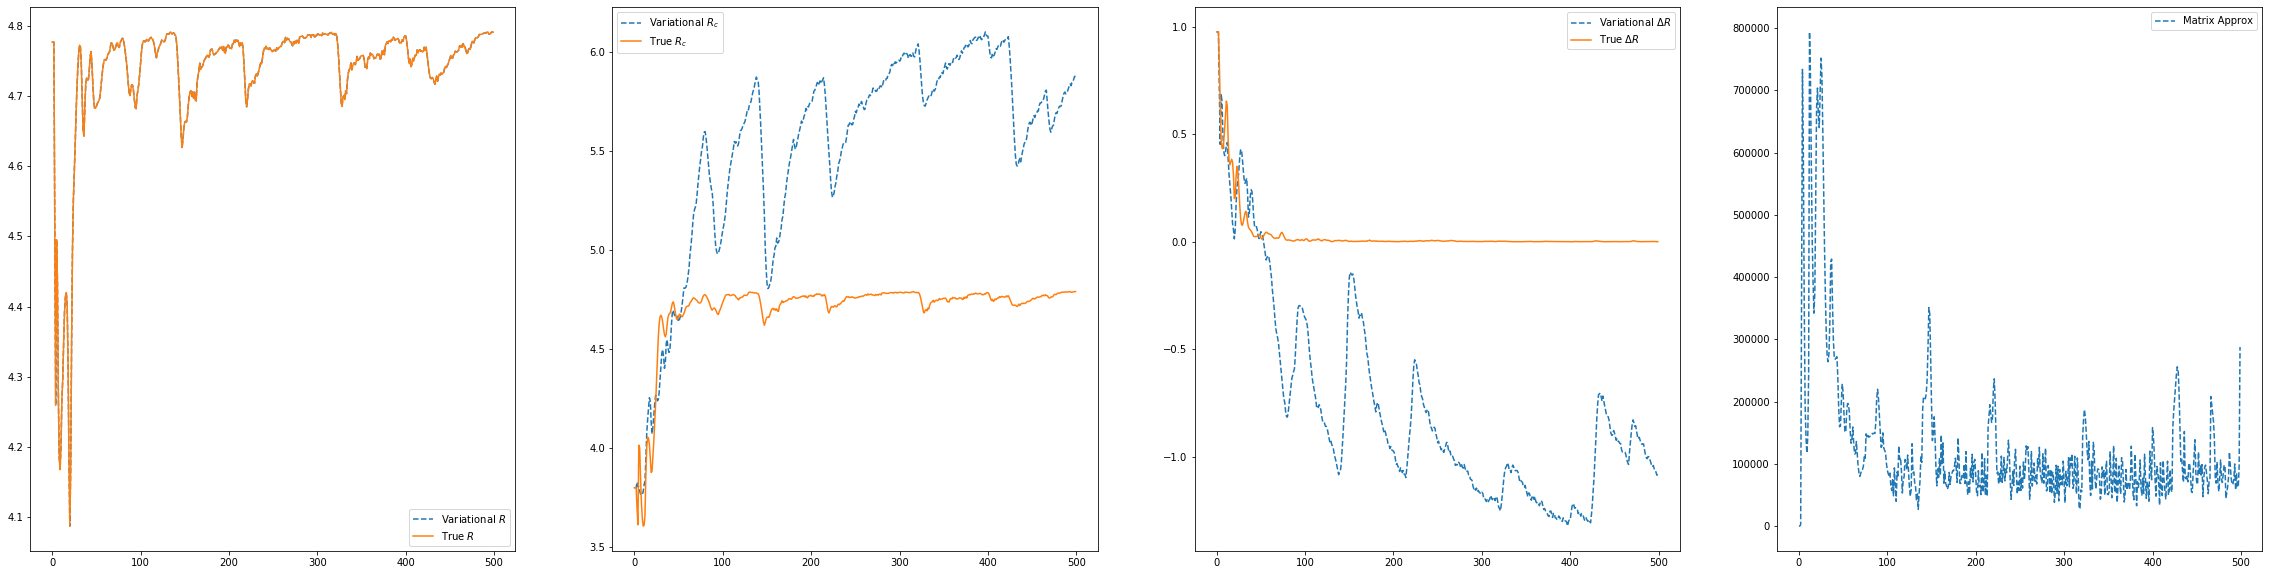

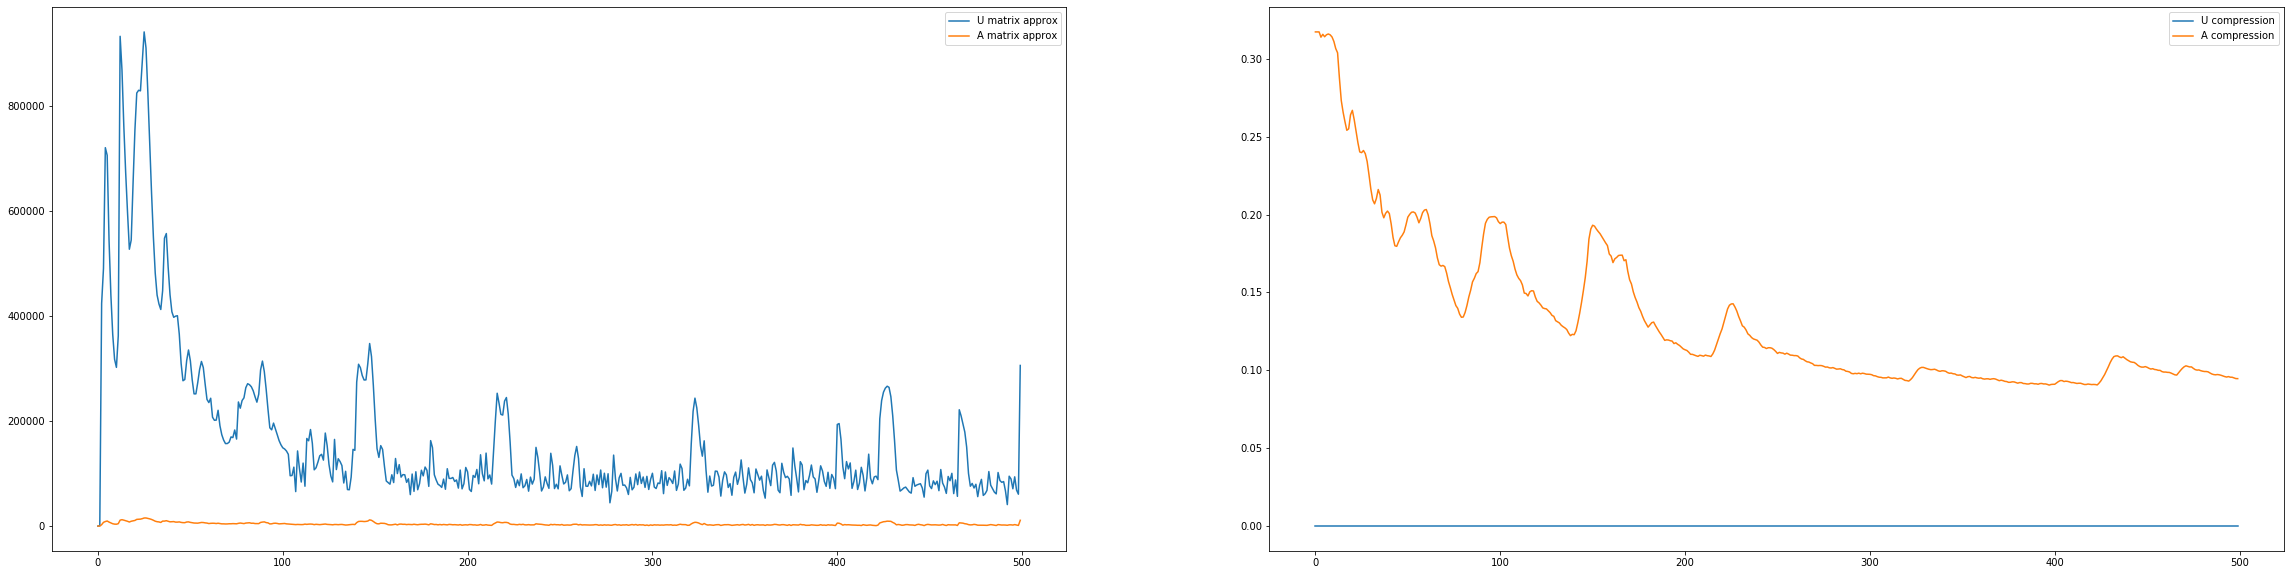

In [241]:
plotter(loss_dict, true_dict, norm)

## Learning Rate Adjusted by Lipschitz Constant

Var MCR 0.9774303436279297 4.792383193969727 3.814952850341797 1.3372664753319441e-08
True MCR 0.9774301052093506 4.792383193969727 3.814953088760376


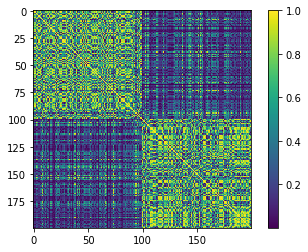

In [302]:
mu = 10
n_classes = 2
lr_G = 0.1 #scaling of the learning rate for Gam
lr_A = 1.0  #scaling of the learning rate for A

Z, Gam, A, Pi = initialize_gaussian(mu=mu)
criterion_mcr2var = MCR2Variational(eps, mu)
criterion_mcr = MCR2(eps)
loss_obj, loss_R, loss_Rc, loss_reg_U = criterion_mcr2var(Z, Pi, A, Gam)
true_obj, true_R, true_Rc = criterion_mcr(Z, Pi)

print('Var MCR', -loss_obj.item(), loss_R.item(), loss_Rc.item(), loss_reg_U.item())
print('True MCR', -true_obj.item(), true_R.item(), true_Rc.item())

In [303]:
optimizer_z = optim.SGD([Z], lr=1e-5)
optimizer_ua = optim.SGD([Gam, A], lr=1e-4)
loss_dict = {'E':[], 'C':[], 'M':[]}
true_dict = {'E':[], 'C':[]}
norm = {'U':[], 'A':[]}
Z_n = F.normalize(Z)
for epoch in range(500):
    if epoch % 1 == 0:
        Z_n = tF.normalize(Z)
        loss_obj, loss_R, loss_Rc, loss_reg_U = criterion_mcr2var(Z_n, Pi, A, Gam)
        true_obj, true_R, true_Rc = criterion_mcr(Z_n, Pi)
        print(epoch, - loss_obj.item(), loss_R.item(), loss_Rc.item(), loss_reg_U.item())
        print(epoch, - true_obj.item(), true_R.item(), true_Rc.item())
            
        loss_dict['E'].append(loss_R.item())
        loss_dict['C'].append(loss_Rc.item())
        loss_dict['M'].append(loss_reg_U.item())
        true_dict['E'].append(true_R.item())
        true_dict['C'].append(true_Rc.item())
        
        
    for step in range(1):
        optimizer_z.zero_grad()
        Z_n = tF.normalize(Z)
        loss_obj = criterion_mcr2var(Z_n, Pi, A, U)
        loss_obj[0].backward()
        
        
        optimizer_z.step()
    for step in range(1):
        Z_n = F.normalize(Z).T
        Z_nrm = torch.zeros(n_classes)
        for i in range(n_classes):
            Z_nrm[i] = torch.norm(Z_n[:,Pi[:,i]>0]@Z_n[:,Pi[:,i]>0].t())

        optimizer_ua.zero_grad() 

        ZtZ2 = (Z_n.t()@Z_n)**2
        APiT = A.T@Pi.t()
        GamTZ2 = (Gam.t()@Z_n)**2
        AAT = A.T@A
        GamTGam2 = (Gam.t()@Gam)**2

        #Calculate the squared frobenius term

        loss_obj, loss_R, loss_Rc, loss_reg_U = criterion_mcr2var(Z_n.T, Pi, A, Gam)
        loss_obj.backward()

        with torch.no_grad():

            La = mu*torch.norm(GamTGam2)
            Lz = 0.0

            for j in range(n_classes):
                Lz += 2*Z_nrm[j]*torch.max(A[:,j]) + 2*torch.max(A[:,j])**2

            Lz = Lz*mu

            A.data = A.data - lr_A/La*A.grad
            Gam.data = Gam.data - lr_G/Lz*Gam.grad

            #clip A to be non-negative
            tF.relu_(A.data)

            #normalize columns of Gam
            Gam = tF.normalize(Gam, dim=0, out=Gam)

0 0.9774303436279297 4.792383193969727 3.814952850341797 1.147019457192755e-08
0 0.9774301052093506 4.792383193969727 3.814953088760376
1 -0.911989688873291 4.79205322265625 3.8265719413757324 1.8774709701538086
1 0.9735898971557617 4.79205322265625 3.8184633255004883
2 -6.008554458618164 4.791606903076172 3.84458065032959 6.955580711364746
2 0.9697427749633789 4.791606903076172 3.821864128112793
3 -13.812870025634766 4.791045188903809 3.8655457496643066 14.73836898803711
3 0.9658908843994141 4.791045188903809 3.8251543045043945
4 -24.015989303588867 4.790369987487793 3.8878302574157715 24.918529510498047
4 0.9620363712310791 4.790369987487793 3.828333616256714
5 -36.37690734863281 4.789583206176758 3.9105958938598633 37.25589370727539
5 0.9581809043884277 4.789583206176758 3.83140230178833
6 -50.68546676635742 4.788686752319336 3.9334421157836914 51.54071044921875
6 0.9543266296386719 4.788686752319336 3.834360122680664
7 -66.74870300292969 4.787682056427002 3.9561867713928223 67.5802

67 -822.046142578125 4.608225345611572 4.805642127990723 821.8487548828125
67 0.7495927810668945 4.608225345611572 3.8586325645446777
68 -815.3990478515625 4.604369640350342 4.808464050292969 815.1949462890625
68 0.7469756603240967 4.604369640350342 3.857393980026245
69 -808.4019775390625 4.600513458251953 4.811089038848877 808.19140625
69 0.744384765625 4.600513458251953 3.856128692626953
70 -801.2158813476562 4.596656799316406 4.81777286529541 800.9947509765625
70 0.741818904876709 4.596656799316406 3.8548378944396973
71 -793.8071899414062 4.592800140380859 4.824044227600098 793.575927734375
71 0.7392792701721191 4.592800140380859 3.8535208702087402
72 -786.1806030273438 4.588944435119629 4.829950332641602 785.9395751953125
72 0.7367653846740723 4.588944435119629 3.8521790504455566
73 -778.3436889648438 4.585090637207031 4.8355231285095215 778.09326171875
73 0.7342774868011475 4.585090637207031 3.850813150405884
74 -770.310791015625 4.581238746643066 4.840784072875977 770.05126953125

138 -306.532958984375 4.358098030090332 4.7334747314453125 306.1575927734375
138 0.6184697151184082 4.358098030090332 3.739628314971924
139 -302.5549011230469 4.355072021484375 4.725727081298828 302.1842346191406
139 0.617225170135498 4.355072021484375 3.737846851348877
140 -298.6732482910156 4.352059364318848 4.717746257781982 298.30755615234375
140 0.6159911155700684 4.352059364318848 3.7360682487487793
141 -294.8858642578125 4.34906005859375 4.709525108337402 294.525390625
141 0.6147685050964355 4.34906005859375 3.7342915534973145
142 -291.1912841796875 4.346073627471924 4.701052665710449 290.8363037109375
142 0.613555908203125 4.346073627471924 3.732517719268799
143 -287.7906188964844 4.3431010246276855 4.697792053222656 287.4359130859375
143 0.6123542785644531 4.3431010246276855 3.7307467460632324
144 -284.6761169433594 4.340139389038086 4.697262287139893 284.3190002441406
144 0.6111617088317871 4.340139389038086 3.728977680206299
145 -281.7164306640625 4.337187767028809 4.6965551

206 -172.46104431152344 4.17654275894165 4.652235984802246 171.9853515625
206 0.5467863082885742 4.17654275894165 3.629756450653076
207 -171.5489501953125 4.174180030822754 4.651634216308594 171.07150268554688
207 0.5458378791809082 4.174180030822754 3.6283421516418457
208 -170.6603240966797 4.171824932098389 4.6510396003723145 170.1811065673828
208 0.5448904037475586 4.171824932098389 3.62693452835083
209 -169.79522705078125 4.169476509094238 4.650452613830566 169.3142547607422
209 0.5439443588256836 4.169476509094238 3.6255321502685547
210 -168.95303344726562 4.167135715484619 4.64987325668335 168.4702911376953
210 0.5429999828338623 4.167135715484619 3.624135732650757
211 -168.13400268554688 4.164801597595215 4.6493024826049805 167.64950561523438
211 0.5420565605163574 4.164801597595215 3.6227450370788574
212 -167.3375244140625 4.162474632263184 4.648738861083984 166.85125732421875
212 0.5411148071289062 4.162474632263184 3.6213598251342773
213 -166.56338500976562 4.160154342651367 

268 -152.91387939453125 4.041540145874023 4.630033493041992 152.32537841796875
268 0.48952579498291016 4.041540145874023 3.5520143508911133
269 -153.10165405273438 4.039520263671875 4.6299004554748535 152.5112762451172
269 0.4886159896850586 4.039520263671875 3.5509042739868164
270 -153.3020477294922 4.037504196166992 4.629772186279297 152.70977783203125
270 0.48770618438720703 4.037504196166992 3.549798011779785
271 -153.51495361328125 4.035491943359375 4.629650115966797 152.92079162597656
271 0.48679637908935547 4.035491943359375 3.5486955642700195
272 -153.74009704589844 4.033483505249023 4.6295318603515625 153.14404296875
272 0.4858865737915039 4.033483505249023 3.5475969314575195
273 -153.97760009765625 4.031479358673096 4.629419326782227 153.37965393066406
273 0.48497772216796875 4.031479358673096 3.546501636505127
274 -154.22755432128906 4.029479026794434 4.629310607910156 153.62771606445312
274 0.4840688705444336 4.029479026794434 3.54541015625
275 -154.4893341064453 4.02748203

329 -182.8745574951172 3.9245502948760986 4.626959800720215 182.17214965820312
329 0.434612512588501 3.9245502948760986 3.4899377822875977
330 -183.5977783203125 3.9227213859558105 4.627140998840332 182.8933563232422
330 0.4337284564971924 3.9227213859558105 3.488992929458618
331 -184.3255615234375 3.9208946228027344 4.627357482910156 183.6190948486328
331 0.4328455924987793 3.9208946228027344 3.488049030303955
332 -185.05776977539062 3.9190707206726074 4.627608299255371 184.34922790527344
332 0.4319629669189453 3.9190707206726074 3.487107753753662
333 -185.7938995361328 3.9172492027282715 4.62789249420166 185.083251953125
333 0.43108129501342773 3.9172492027282715 3.4861679077148438
334 -186.5341339111328 3.9154293537139893 4.628210544586182 185.82135009765625
334 0.43020033836364746 3.9154293537139893 3.485229015350342
335 -187.2777557373047 3.9136126041412354 4.6285600662231445 186.56280517578125
335 0.4293200969696045 3.9136126041412354 3.484292507171631
336 -188.025634765625 3.911

392 -232.66812133789062 3.8137497901916504 4.679058074951172 231.8028106689453
392 0.38089561462402344 3.8137497901916504 3.432854175567627
393 -233.47561645507812 3.8120641708374023 4.680312633514404 232.60736083984375
393 0.38008737564086914 3.8120641708374023 3.431976795196533
394 -234.28216552734375 3.8103809356689453 4.6815948486328125 233.41094970703125
394 0.37928104400634766 3.8103809356689453 3.4310998916625977
395 -235.08714294433594 3.8087000846862793 4.6829023361206055 234.2129364013672
395 0.3784770965576172 3.8087000846862793 3.430222988128662
396 -235.89060974121094 3.807021379470825 4.684234619140625 235.01339721679688
396 0.377673864364624 3.807021379470825 3.429347515106201
397 -236.6927490234375 3.8053455352783203 4.685589790344238 235.8125
397 0.376873254776001 3.8053455352783203 3.4284722805023193
398 -237.49337768554688 3.8036718368530273 4.6869659423828125 236.61007690429688
398 0.37607431411743164 3.8036718368530273 3.4275975227355957
399 -238.2921600341797 3.80

460 -275.7530212402344 3.704608678817749 4.854586601257324 274.6030578613281
460 0.33090806007385254 3.704608678817749 3.3737006187438965
461 -276.1538391113281 3.703087091445923 4.856740474700928 275.00018310546875
461 0.3302571773529053 3.703087091445923 3.3728299140930176
462 -276.5475769042969 3.7015678882598877 4.858844757080078 275.3902893066406
462 0.3296077251434326 3.7015678882598877 3.371960163116455
463 -276.9355163574219 3.7000508308410645 4.860898017883301 275.774658203125
463 0.3289613723754883 3.7000508308410645 3.371089458465576
464 -277.3172302246094 3.6985363960266113 4.862900257110596 276.1528625488281
464 0.32831764221191406 3.6985363960266113 3.3702187538146973
465 -277.6920471191406 3.69702410697937 4.8648505210876465 276.52423095703125
465 0.32767653465270996 3.69702410697937 3.36934757232666
466 -278.06109619140625 3.695513963699341 4.866747856140137 276.8898620605469
466 0.3270375728607178 3.695513963699341 3.368476390838623
467 -278.4234924316406 3.69400644302

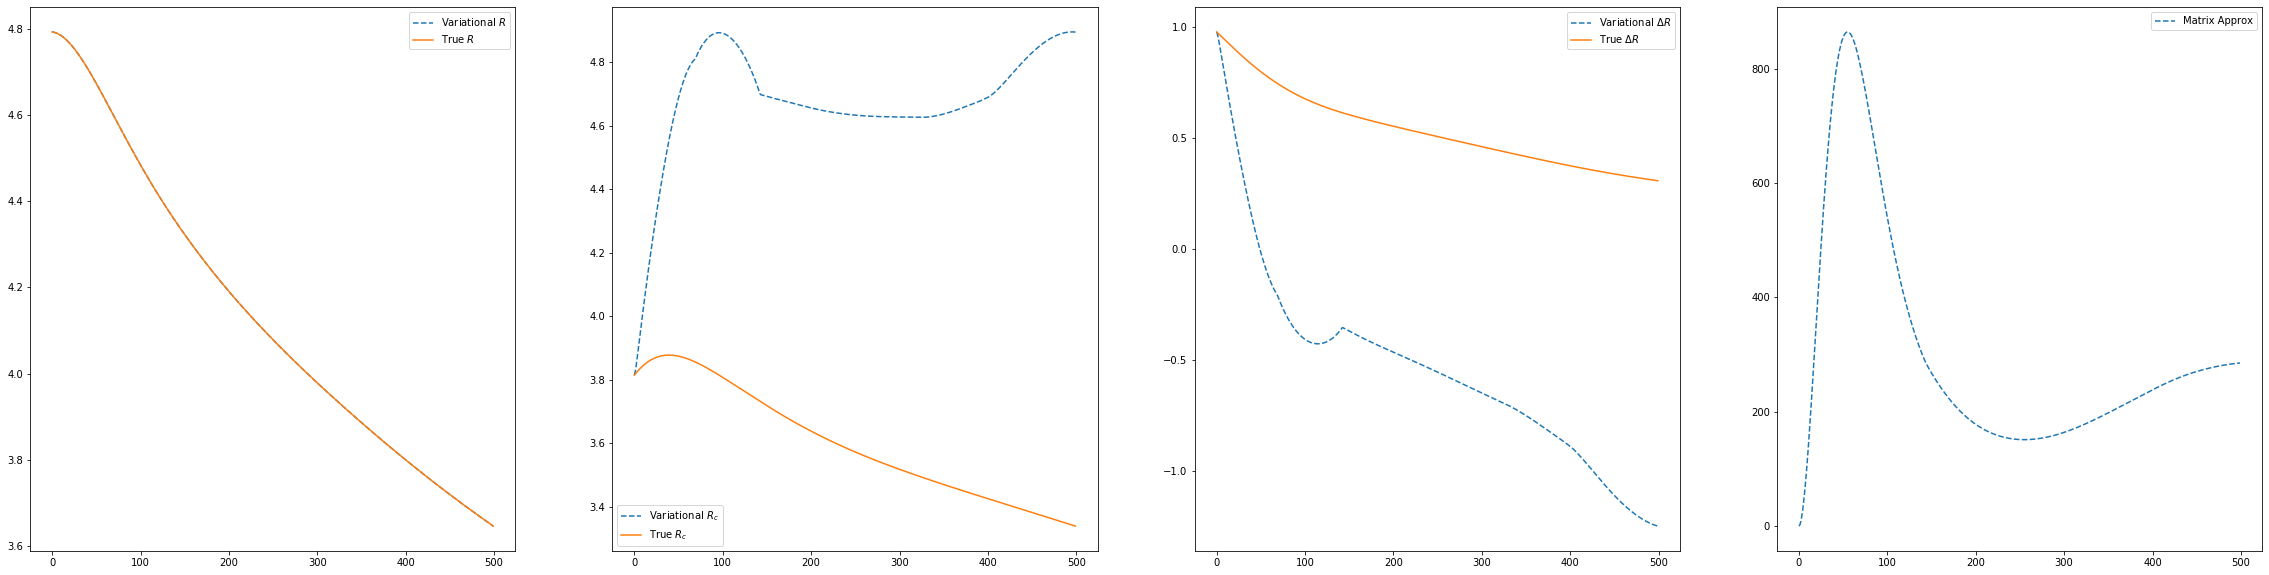

In [304]:
plotter(loss_dict, true_dict, None)

## Plot

In [267]:
def plotter(loss_dict, true_dict, norm):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(40,10))
    ax[1].plot(loss_dict['C'], linestyle='--', label=r'Variational $R_c$')
    ax[0].plot(loss_dict['E'], linestyle='--',label=r'Variational $R$')
    ax[2].plot(np.array(loss_dict['E']) - np.array(loss_dict['C']), linestyle='--', label=r'Variational $\Delta R$')
    ax[3].plot(loss_dict['M'], linestyle='--', label='Matrix Approx')

    ax[1].plot(true_dict['C'], label=r'True $R_c$')
    ax[0].plot(true_dict['E'], label=r'True $R$')
    ax[2].plot(np.array(true_dict['E']) - np.array(true_dict['C']), label=r'True $\Delta R$')

    [ax[i].legend() for i in range(4)]
    
    if norm is not None:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(40,10))
        U_norm = np.array(norm['U'])
        A_norm = np.array(norm['A'])
        ax[0].plot(U_norm[:,0], label='U matrix approx')
        ax[0].plot(A_norm[:,0], label='A matrix approx')

        ax[1].plot(U_norm[:,1], label='U compression')
        ax[1].plot(A_norm[:,1], label='A compression')

        [ax[i].legend() for i in range(2)]

## Augmented Lagrangian